## Creating Lo-Fi data for oscillatory shear rheometry, storage modulus, $G'$
In this notebook, the synthetic generation of Lo-Fi data is introduced based on the given Hi-Fi data. For this case, strain (`St`), temperature (`T`), and angular frequency (`w`) are the independent variables, while the storage modulus (`Gp`) is the dependent variable for which we wish to generate Lo-Fi data. The output of this notebook is `Data_LF_AS_Gp.xlsx`, which is the Lo-Fi storage modulus ($G'$) data.

### Importing dependencies
Note that the below classses from `sklearn` are called as kernels to generate Lo-Fi data.

In [15]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
import itertools
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor

### Loading Hi-Fi data to generate Lo-Fi data based on it.
Similar to the steady shear rheometry, it is possible to sample the data and/or exclude experiments, i.e., storage modulus curves in this case. Strain, angular frequency, and loss modulus are log-scaled here. These variables, along with `T`, are normalized afterwards. As an example, the $T=40^\circ\text{C}$ storage modulus test is masked here (and also during the MFNN training).

In [16]:
np.set_printoptions(suppress=True)
path = os.getcwd()
files = os.listdir(path)
df = {}
url = 'https://github.com/procf/RhINNs/raw/main/MFNN/Oscillatory/Data_HF_AS_Gp.xlsx'
#Uncomment the below line to run locally
# url = pd.ExcelFile('Data_HF_AS_Gp.xlsx')

df = pd.read_excel(url, sheet_name=None)
data = [[k,v] for k,v in df.items()] #k is the sheet name, v is the pandas df
i = 0
data[i][1] = data[0][1].dropna()
data[i][1] = data[i][1][data[i][1].Temperature != 40.]

St, T, w = data[i][1]['Strain'], data[i][1]['Temperature'], data[i][1]['AngFreq']
Gp = data[i][1]['StorageM']

St = np.log10(St)
w = np.log10(w)
Gp = np.log10(Gp)
wmin, wmax = np.log10(0.1), np.log10(600.)

lb = [min(St), 10., wmin, min(Gp)]
ub = [max(St), 50., wmax, max(Gp)]

def norm(vectors, lb, ub):
    normalized_vectors = (vectors - lb) / (ub - lb)
    return normalized_vectors

St = norm(St, lb[0], ub[0])
T = norm(T, lb[1], ub[1])
w = norm(w, wmin, wmax)
Gp = norm(Gp, lb[3], ub[3])

### Performing regression on Hi-Fi data by calling `fitter` with a desired kernel, e.g., `LR`

In [19]:
X = np.stack((St, T, w), axis=1)
y = Gp
T_f = norm(np.array([10., 20., 25., 30., 40.]), lb[1], ub[1])
St_f = norm(np.log10(np.array([10., 100.])), lb[0], ub[0])
N_w = 10*int(len(X)/(len(T_f)*len(St_f)))
w_f = norm(np.linspace(wmin, wmax, N_w), wmin, wmax)
X_f=np.array(list(itertools.product(St_f, T_f, w_f)))

def fitter(mode, X, X_pred):
    if mode == 'LR':
        poly = PolynomialFeatures(degree=1)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        model.fit(X_poly, y)
        X_pred = poly.fit_transform(X_pred)
        return model.predict(X_pred)
    elif mode == 'EN':
        model = ElasticNet(alpha=0.1, l1_ratio=0.5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'RF':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'SVR':
        model = SVR(kernel='rbf', C=2, gamma=5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'GB':
        model = GradientBoostingRegressor(n_estimators=100,
                                          learning_rate=0.1,
                                          max_depth=2, random_state=0)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'kNN':
        model = model = KNeighborsRegressor(n_neighbors=6,
                                            weights='distance',
                                            algorithm='auto',
                                            leaf_size=40, p=2)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'BR':
        model = BayesianRidge()
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'MLP':
        model = MLPRegressor(hidden_layer_sizes=(40, 40, 40),
                             activation='tanh', max_iter=50000,
                            random_state=4, solver='lbfgs')
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'Ridge':
        model = Ridge(alpha=1.0)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'Lasso':
        model = Lasso(alpha=0.1)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'DT':
        model = DecisionTreeRegressor(max_depth=5)
        model.fit(X, y)
        return model.predict(X_pred)
    elif mode == 'AB':
        base_model = DecisionTreeRegressor(max_depth=3)
        model = AdaBoostRegressor(base_model, n_estimators=50, learning_rate=0.1)
        model.fit(X, y)
        return model.predict(X_pred)
y_f = fitter('LR', X, X_f) #LR, EN, RF, SVR, GB, kNN, BR

### Visualizing the generated Lo-Fi data against the Hi-Fi data

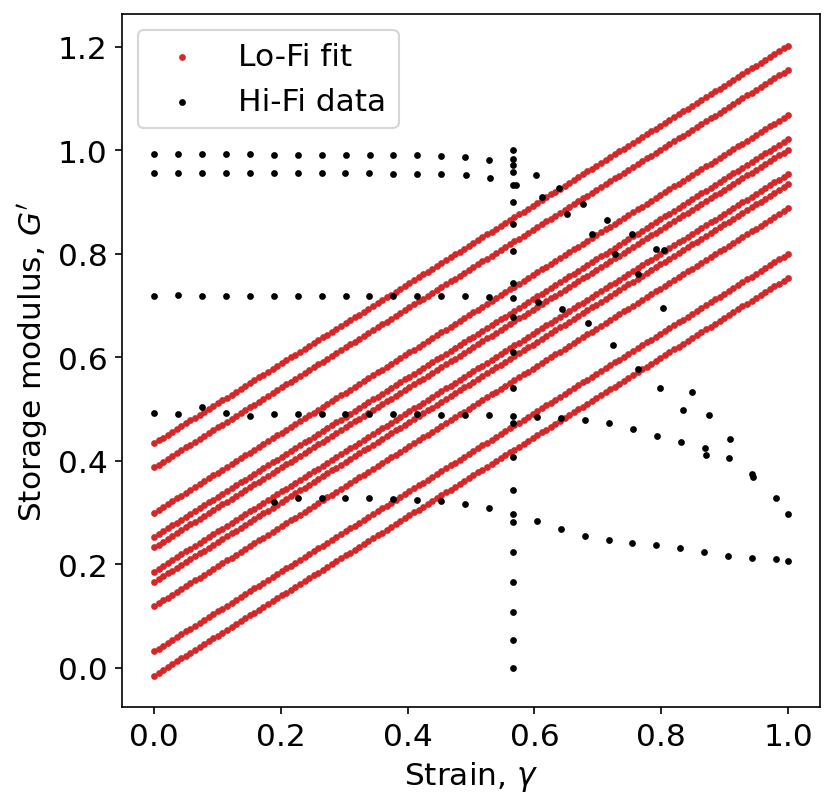

In [21]:
plt.figure(figsize=(6,6), dpi=150)
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize
plt.rc('figure', titlesize=15)  # fontsize of the figure title
plt.scatter(X_f[:,2], y_f, label='Lo-Fi fit', color='tab:red', s=5)
plt.scatter(X[:,0], y, label='Hi-Fi data', color='k', s=5)
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.ylabel('Storage modulus, $G\'$')
plt.xlabel('Strain, $\gamma$')
plt.show()

### Exporting the Lo-Fi data to `Data_LF_AS_Gp.xlsx` (optional)
You may store this excel file locally, or use Google Colab, which has access to `Data_LF_AS_Gp.xlsx` on GitHub.

In [22]:
St_LF, T_LF, w_LF = X_f[:,0], X_f[:,1], X_f[:,2]
Gp_LF = y_f
df_LF_raw = np.stack((St_LF, T_LF, w_LF, Gp_LF), axis=1)
df_LF = pd.DataFrame(df_LF_raw, columns = ['Strain','Temperature','AngFreq',
                                          'StorageM'])
df_LF.to_excel("Data_LF_AS_Gp.xlsx", index=False)